# Self-customized Job Posting Selector

In [4]:
from selenium import webdriver
import pandas as pd
from bs4 import BeautifulSoup
import time
import random
from selenium.webdriver.common.keys import Keys
from datetime import datetime
import re

## Web-scraping

Specify your requirements

In [20]:
# level
level = str(input("Enter experience level(entry/mid/senior): ")).lower()+'_level'

# location
location = str(input("Enter location: ")).lower().replace(' ','+')

# job query
query = str(input("Enter keywords: ")).lower().replace(' ','+')

url_link = 'https://www.indeed.com/jobs?q='+query+'&l='+location+'&explvl='+level
print(f'Your search url is ready: {url_link}')

Enter experience level(entry/mid/senior): entry
Enter location: California
Enter keywords: data analyst
Your search url is ready: https://www.indeed.com/jobs?q=data+analyst&l=california&explvl=entry_level


In [70]:
query = 'data+scientist'
location = 'California'
level = 'entry_level'
url_link = 'https://www.indeed.com/jobs?q='+query+'&l='+location+'&explvl='+level

In [71]:
# Check if the link looks good
url_link

'https://www.indeed.com/jobs?q=data+scientist&l=California&explvl=entry_level'

In [1]:
# Store pages in a table called postings
postings = pd.DataFrame(columns=['title','location','company','urgent','job_description','date_released','job_ID'])
driver = webdriver.Chrome('chromedriver')

starttime = datetime.now()
start = time.time()
for i in range(0,30):
    time.sleep(random.randint(1,3)+random.random())

    driver.get(str(url_link)+'&sort=date&start='+str(10*i))
    search_results = driver.find_elements_by_class_name('result')

    for result in search_results:
        result_html = result.get_attribute('innerHTML')
        soup = BeautifulSoup(result_html,'html.parser')
        sleep_time = random.randint(0,2) + random.random()  
    
        # find elements we need for each clickcard
        ## Job title
        try:
            job_title = soup.find('a',{'class':'jobtitle'}).text.replace('\n','')
        except:
            job_title = None

        ## Job location
        try:
            job_location = soup.find('',{'class':'location'}).text.split(',')[0]
        except:
            job_location = None

        ## Company
        try:
            company = soup.find('',{'class':'company'}).text.replace('\n','')
        except:
            company = None

        ## Date released
        try:
            release_date = soup.find('',{'class':'date'}).text.replace('\n','')
        except:
            release_date = None

        ## job description
        try:
            summary = result.find_elements_by_class_name('summary')[0]
            summary.click()
        except:
            webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()
            summary = result.find_elements_by_class_name('title')[0]
            summary.click()
            
        try:
            driver.implicitly_wait(5)
            jd = driver.find_element_by_id('vjs-desc').text.strip()
            print('page '+str(i)+' jd')
        except:
            jd = None
            print('page '+str(i)+' failed')
        
        ## Job ID
        jobID = driver.find_element_by_css_selector("div.jobsearch-SerpJobCard.unifiedRow.row.result.clickcard.vjs-highlight").get_attribute('id')

        ## Urgent or not
        try:
            urgent = driver.find_element_by_class_name('serpvj-UrgentlyHiringMessage-text').text
        except:
            urgent = None

        postings = postings.append({'title': job_title,'location':job_location,'company':company,\
                                    'job_description':jd,'urgent':urgent,'date_released':release_date,'job_ID':jobID},ignore_index=True)

driver.close()
end = time.time()

print('Finished')
print('start from time:'+str(starttime))
print(f"Runtime of the program is {end - start}")

## Process data

Before further analysis, first we need to process the data

### Merge several datasets

In [8]:
data_analyst = pd.read_csv('postings_data_analyst.csv')
data_science = pd.read_csv('postings_data_science.csv')
data_scientist = pd.read_csv('postings_data_scientist.csv')
data_visualization = pd.read_csv('postings_data_visualization.csv')
product_analyst = pd.read_csv('postings_product_analyst.csv')
machine_learning = pd.read_csv('postings_machine_learning.csv')

frame = [data_analyst,data_science,data_scientist,data_visualization,machine_learning,product_analyst]
all_postings = pd.concat(frame)

C:\Users\nora_\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [9]:
all_postings.reset_index(drop=True,inplace=True)

In [11]:
# Might have many job postings overlapping 
postings = all_postings.drop_duplicates()
postings.reset_index(inplace=True,drop=True)

### Process ID

In [3]:
postings['job_ID'] = [x.split('_')[1] for x in postings.job_ID]

In [6]:
# Create a url column so I can relate back to the webpage
postings['url'] = [url_link+'&vjk='+x for x in postings.job_ID]

### Process date

In [241]:
# We keep only postings released within 30 days
postings = postings[postings['date_released']!='30+ days ago']
postings.reset_index(inplace=True,drop=True)

days = []
for i in range(0,len(postings)):
    if postings.date_released[i]=='Just posted':
        days_ago = 0
    elif postings.date_released[i]=='Today':
        days_ago = 0
    else:
        days_ago = int(postings.date_released[i].split(" ")[0])
    days.append(days_ago)
postings['days_ago']=days

### Process job description text

In [244]:
# Replace all the newline symbol with space since paragraphs won't matter
postings['clean_text'] = [x.replace('\n',' ') for x in postings.job_description]

# Convert all strings to lowercase
postings.clean_text = [x.lower() for x in postings.clean_text]

# Replace all punctuations to space
postings.clean_text = [re.sub(r"[()-/:,.;@#?!&$]+\ *", " ", x) for x in postings.clean_text]

C:\Users\nora_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Customize the Job Selector

1. Create meaningful metrics according to my portfolio<br>
2. Quantify by giving each metric a weight and calculate overall score 

In [15]:
# A customized keyword list is used to match skills with job requirements
keywords = pd.read_csv('keywords_for_ranking.csv')
keywords.columns

Index(['Database', 'Python', 'R', 'Big Data', 'Data Manipulation',
       'Data Visualization', 'Stats', 'Machine Learning', 'NLP',
       'Cloud Computing', 'Deep Learning'],
      dtype='object')

In [16]:
# Create word lists for different skills:
def create_word_list(column):
    raw_list = column.tolist()
    cleaned_list = [x for x in raw_list if str(x) != 'nan']
    return cleaned_list

# Create a dict to store the keywords for each skill
keyword_lists = {} 
for i in range(0,len(keywords.columns)):
    name = str(keywords.columns[i])
    value = create_word_list(keywords[keywords.columns[i]])
    keyword_lists.update({name:value})

In [19]:
keyword_lists['Cloud Computing']

['gcp',
 'aws',
 'cloud',
 'cloud certificate',
 'gpu',
 'google cloud',
 'amazon web service',
 'cloud computing']

In [356]:
# Check the appearance of keywords:
def count_keywords(list_name,row):
    list_to_count = [w for w in list_name if w in row]
    keyword_count = len(list_to_count)
    return keyword_count

In [358]:
# For each skill, we count the keywords that appear in every job description
## and form new labels

keyword_label = {}
for j in keywords.columns:
    name = str(j)
    count_list = []
    for i in range(0,len(postings)):
        keyword_count = count_keywords(keyword_lists[name],postings.clean_text[i])
        count_list.append(keyword_count)
    keyword_label.update({name:count_list})

In [359]:
# Take a look at how the data is like
labels = pd.DataFrame.from_dict(keyword_label)

In [1]:
new_posting = pd.merge(postings, labels, left_index=True, right_index=True)
new_posting

In [361]:
new_posting.reset_index(inplace=True)

In [2]:
for i in keywords.columns:
    print(new_posting.groupby(str(i)).agg({'index':len}))

### Create new metrics for comparison

A way to quantify the matchness of the job -- build a job matchness score<br>
Set up metrics according to my job preference

#### Location

In [364]:
# Read the location information csv
location_info = pd.read_csv('location.csv')
location_info = location_info[['location','relocate']]

In [365]:
new_posting = new_posting.merge(location_info,how='left',left_on='location',right_on='location')

#### Date released

In [401]:
# If a job is newly released it means my resume would have higher exposure
new_posting['new_released'] = [2 if x <=5 else 0 if x >20 else 1 for x in new_posting.days_ago]

#### Programming Language

In [366]:
new_posting['language'] = new_posting['R']+new_posting['Python']+new_posting['Database']+new_posting['Big Data']

In [367]:
# Set language == 1 if any of the 3 columns !=0
new_posting.language = [1 if x !=0 else 0 for x in new_posting.language]

In [368]:
# See what the proportion is
len(new_posting[new_posting.language==0])/len(new_posting)

0.5051334702258727

#### Weight different analysis skills

In [369]:
# I create a metric to flag basic data analysis skills such as data manipulation and data visualization
new_posting['basic_analytics'] = new_posting['Data Manipulation']+new_posting['Data Visualization']
new_posting.basic_analytics = [1 if x !=0 else 0 for x in new_posting.basic_analytics]
len(new_posting[new_posting.basic_analytics==0])/len(new_posting)

0.7700205338809035

In [371]:
# Then using similar method, I made metrics for advanced analytics skills and specialized skills
## Advanced skills
new_posting['advanced_analytics'] = new_posting['Stats']+new_posting['Machine Learning']
new_posting.advanced_analytics = [1 if x !=0 else 0 for x in new_posting.advanced_analytics]
print(len(new_posting[new_posting.advanced_analytics==0])/len(new_posting))

## Specialized skills
new_posting['specialized_analytics'] = new_posting['NLP']+new_posting['Cloud Computing']+new_posting['Deep Learning']
new_posting.specialized_analytics = [1 if x !=0 else 0 for x in new_posting.specialized_analytics]
print(len(new_posting[new_posting.specialized_analytics==0])/len(new_posting))

0.5420944558521561
0.3675564681724846


In [381]:
new_posting.columns

Index(['index', 'company', 'date_released', 'job_description', 'location',
       'title', 'urgent', 'days_ago', 'clean_text', 'Stats', 'Database',
       'Python', 'R', 'Big Data', 'Data Manipulation', 'Data Visualization',
       'Machine Learning', 'NLP', 'Cloud Computing', 'Deep Learning',
       'relocate', 'language', 'basic_analytics', 'advanced_analytics',
       'specialized_analytics', 'overall_score'],
      dtype='object')

In [587]:
# Overall score
new_posting['overall_score'] = 20*new_posting.language+\
                               +7.5*(new_posting[['Data Manipulation', 'Data Visualization']].sum(axis=1))\
                               +10*(new_posting[['Stats','Machine Learning']].sum(axis=1))\
                               +5*(new_posting[['NLP', 'Cloud Computing', 'Deep Learning']].sum(axis=1))\
                               +(-20)*new_posting.relocate+5*new_posting.new_released

In [588]:
final_ranking = new_posting.sort_values(by='overall_score',ascending=False).reset_index(drop=True)

In [3]:
ranking_table = final_ranking[final_ranking['overall_score']>=60][['company','job_description','language','basic_analytics','advanced_analytics','specialized_analytics','relocate','overall_score']]
ranking_table

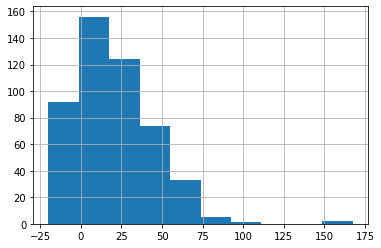

In [590]:
final_ranking.overall_score.hist()

In [574]:
final_ranking.to_csv('final_ranking_posting.csv',index=False)